<a href="https://colab.research.google.com/github/FrankJRix/MF_gen_proto/blob/main/proc_gen_playground.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [174]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('pdf', 'svg')
np.set_printoptions( linewidth=200)

N_ROOMS = 25
MAX_WEIGHT = 180
FRACTION = 0.3
SIGMA_FACTOR = 0.15
BIAS_ZER0 = MAX_WEIGHT / 10
BIAS_M = 0 # MAX_WEIGHT / 18

DISTRIBUTION_PLOT = False

class Room:
    # room of the dungeon generator whatever
    global_id = 0
    def __init__(self, lr, ud):
        type(self).global_id += 1
        self.id = type(self).global_id
        self.instance_id = -1

        self.angle_lr = lr
        self.angle_ud = ud # might not be an angle
        self.base_weight = lr + 2*ud # experimental
        self.weight_modifier = 1 # placeholder

        self.up = []
        self.down = []
        self.left = []
        self.right = []

        self.pos = [0,0,0]
        self.rotation = 0

        self.can_walk_back = False
        self.can_fly_back = False

    def get_copy(self):
        r = Room(self.angle_lr, self.angle_ud)
        r.id = self.id
        r.can_walk_back = self.can_walk_back
        r.can_fly_back = self.can_fly_back

        return r

    def set_instance_id(self, id):
        self.instance_id = id

    def reset(self):
        self.up = []
        self.down = []
        self.left = []
        self.right = []

        self.pos = [0,0,0]
        self.rotation = 0

        self.can_walk_back = False
        self.can_fly_back = False

    def __str__(self):
        return f"instance_id: {self.instance_id}, id: {self.id}, lr: {self.angle_lr}, ud: {self.angle_ud}, up: {get_ids_from_list(self.up)}, down: {get_ids_from_list(self.down)}, left: {get_ids_from_list(self.left)}, right: {get_ids_from_list(self.right)}, pos: {self.pos}, rotation: {self.rotation}, base_weight: {self.base_weight}"

N = 20
class RoomBin:
    def __init__(self, inf, sup):
        self.inf = inf
        self.sup = sup
        self.content = []

    def get_fullness(self):
        return len(self.content) >= N

    def get_room(self):
        i = np.random.randint(0, len(self.content))
        return self.content[i].get_copy()

    def __str__(self):
        return f"[{self.inf}, {self.sup}); contains {len(self.content)} rooms"

class RoomPool:
    def __init__(self, n_bins):
        self.n_bins = n_bins
        self.bin_size = MAX_WEIGHT / n_bins
        self.bins = []
        self.populate()

    def select_bin(self, score):
        for b in self.bins:
            if score >= b.inf and score <= b.sup:
                return b

    def get_room(self, score):
        b = self.select_bin(score)
        return b.get_room()

    def get_fullness(self):
        a = True
        for bin in self.bins:
            a = a and bin.get_fullness()
        return a

    def populate(self):
        Room.global_id = 0
        self.bins = []
        for i in range(self.n_bins):
            b = RoomBin(self.bin_size*i, self.bin_size*(i+1))
            self.bins.append(b)

        while not self.get_fullness():
            phi = np.random.randint(-BIAS_ZER0, MAX_WEIGHT+BIAS_M) / 2
            theta = np.random.randint(-BIAS_ZER0, MAX_WEIGHT+BIAS_M) / 4

            phi = max(0, phi)
            phi = min(phi, MAX_WEIGHT/2)
            theta = max(0, theta)
            theta = min(theta, MAX_WEIGHT/4)

            r = Room(phi, theta)
            b = self.select_bin(r.base_weight)
            if not b.get_fullness():
                b.content.append(r)

class Path:
    def __init__(self):
        self.rooms = []

    # <- overridare add e sub per combinare paths in mappa totale e subpath differenziale

    def __len__(self):
        return len(self.rooms)

    def __getitem__(self, key):
        return self.rooms[key]

    def __setitem__(self, key, value):
        self.rooms[key] = value

    def append(self, item):
        self.rooms.append(item)

    def print(self):
        for r in self.rooms:
            print(r)
            print()

class Map:
    def __init__(self, pool):
        self.pool = pool
        self.global_positions = []
        self.main_path = Path()

        self.phase_one()

    def flush(self):
        self.global_positions = []
        for r in self.main_path:
            r.reset()
        self.main_path = Path()

    def draw(self):
        # implementazione provvisoria a path singolo
        map = np.array(self.global_positions)
        mn = min(map[:,0].min(), map[:,1].min())
        mx = max(map[:,0].max(), map[:,1].max())

        a = plt.figure(figsize = (10,10))

        plt.subplot(2, 2, 1)
        plt.scatter(map[:,0], map[:,1], marker='.', color='black')
        plt.plot(map[:,0], map[:,1], linestyle='--', color='black', alpha=0.2)
        plt.xlabel('x')
        plt.ylabel('y')
        plt.xlim(mn-2, mx+2)
        plt.ylim(mn-2, mx+2)
        plt.grid(linestyle = '-.')
        for i in range(len(self.main_path)):
            plt.annotate(f"{self.main_path[i].instance_id}", xy=(map[i,0], map[i,1]), xytext=(map[i,0]-1, map[i,1]+1))

        plt.subplot(2, 2, 4)
        plt.scatter(map[:,1], map[:,2], marker='.', color='black')
        plt.plot(map[:,1], map[:,2], linestyle='--', color='black', alpha=0.2)
        plt.xlabel('y')
        plt.ylabel('z')
        plt.xlim(mn-2, mx+2)
        plt.ylim(map[:,2].min()-2, map[:,2].max()+2)
        plt.grid(linestyle = '-.')

        plt.subplot(2, 2, 3)
        plt.scatter(map[:,0], map[:,2], marker='.', color='black')
        plt.plot(map[:,0], map[:,2], linestyle='--', color='black', alpha=0.2)
        plt.xlabel('x')
        plt.ylabel('z')
        plt.xlim(mn-2, mx+2)
        plt.ylim(map[:,2].min()-2, map[:,2].max()+2)
        plt.grid(linestyle = '-.')

        ax = plt.subplot(2, 2, 2, projection='3d')
        ax.scatter(map[:,0], map[:,1], map[:,2], marker='x', color='black')
        ax.plot(map[:,0], map[:,1], map[:,2], linestyle='--', color='black', alpha=0.1)
        plt.xlabel('x')
        plt.ylabel('y')

        a.suptitle(f"N_ROOMS = {N_ROOMS}, MAX_WEIGHT = {MAX_WEIGHT}, FRACTION = {FRACTION}, SIGMA_FACTOR = {SIGMA_FACTOR}")
        plt.tight_layout()
        #plt.savefig("mf_dungeon_test.pdf", bbox_inches='tight')
        plt.show()

    def phase_one(self):
        self.flush()

        for i in range(N_ROOMS):
            p = self.pool
            x = slifat_normal(i)
            x = max(0, x)
            x = min(x, MAX_WEIGHT)
            r = p.get_room(x)

            r.set_instance_id(i)
            self.main_path.append(r)

            if i != 0:
                r.up.append(self.main_path[i-1])
                self.main_path[i-1].down.append(r)

        D = 5 # poi sarà somma delle lunghezze delle stanze blablah
        for i in range(len(self.main_path)-1):
            self.main_path[i+1].pos[0] = self.main_path[i].pos[0] + D * np.cos( np.radians( self.main_path[i].rotation ) )
            self.main_path[i+1].pos[1] = self.main_path[i].pos[1] + D * np.sin( np.radians( self.main_path[i].rotation ) )
            self.main_path[i+1].pos[2] = self.main_path[i].pos[2] - D * np.sin( np.radians( self.main_path[i].angle_ud ) )

            self.main_path[i+1].rotation = (self.main_path[i].rotation + self.main_path[i+1].angle_lr) % 360

        for i in range(len(self.main_path)):
            self.global_positions.append(self.main_path[i].pos)

        self.draw()

def get_ids_from_list(list):
    ids = []
    for e in list:
        ids.append(f"{e.id}, {e.instance_id}")
    return ids

l = [Room(0,0), Room(0,0), Room(0,0)]


def compute_sfn_parameters(n):
    M = MAX_WEIGHT
    N = N_ROOMS

    m = FRACTION * M/N

    mu = m * n
    sigma = SIGMA_FACTOR * (M + M*n/N)

    return mu, sigma

def slifat_normal(step, dim = 1):
    mu, sigma = compute_sfn_parameters(step)

    return np.random.normal(mu, sigma, dim).round().item()

def slifat_normal_fun(t, step):
    mu, sigma = compute_sfn_parameters(step)

    return np.sqrt(1 / (2 * np.pi * sigma**2)) / np.exp((t - mu)**2 / (2 * sigma**2))

In [175]:
# @title Proof of concept
t = np.linspace(0, MAX_WEIGHT, 200)
dim = 1
dungeon = []

if DISTRIBUTION_PLOT:
    plt.figure(figsize=(10,7))
for step in range(N_ROOMS+1):
    if DISTRIBUTION_PLOT:
        plt.plot(t, slifat_normal_fun(t, step))

    w = max(0, slifat_normal(step, dim))
    w = min(w, MAX_WEIGHT)
    z = max(0, slifat_normal(step, dim))
    z = min(z, MAX_WEIGHT)

    dungeon.append(Room(w/2, z/4))

if DISTRIBUTION_PLOT:
    plt.grid(True, 'both', linestyle='--')
    plt.xlim(0, MAX_WEIGHT)
    plt.tight_layout()

D = 5
for i in range(len(dungeon)-1):

    dungeon[i+1].pos[0] = dungeon[i].pos[0] + D * np.cos( np.radians( dungeon[i].rotation ) )
    dungeon[i+1].pos[1] = dungeon[i].pos[1] + D * np.sin( np.radians( dungeon[i].rotation ) )

    dungeon[i+1].pos[2] = dungeon[i].pos[2] - D * np.sin( np.radians( dungeon[i].angle_ud ) )
    dungeon[i+1].rotation = (dungeon[i].rotation + dungeon[i+1].angle_lr) % 360

map = []
for r in dungeon:
    map.append(r.pos)
map = np.array(map)

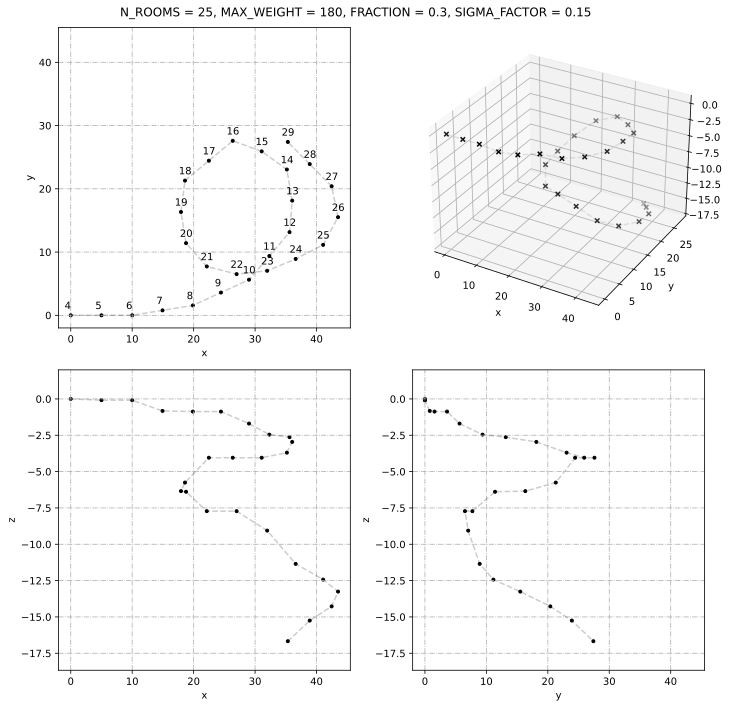

In [176]:
# @title Proof of concept
mn = min(map[:,0].min(), map[:,1].min())
mx = max(map[:,0].max(), map[:,1].max())

a = plt.figure(figsize = (10,10))

plt.subplot(2, 2, 1)
plt.scatter(map[:,0], map[:,1], marker='.', color='black')
plt.plot(map[:,0], map[:,1], linestyle='--', color='black', alpha=0.2)
plt.xlabel('x')
plt.ylabel('y')
plt.xlim(mn-2, mx+2)
plt.ylim(mn-2, mx+2)
plt.grid(linestyle = '-.')
for i in range(len(dungeon)):
    plt.annotate(f"{dungeon[i].id}", xy=(map[i,0], map[i,1]), xytext=(map[i,0]-1, map[i,1]+1))

plt.subplot(2, 2, 4)
plt.scatter(map[:,1], map[:,2], marker='.', color='black')
plt.plot(map[:,1], map[:,2], linestyle='--', color='black', alpha=0.2)
plt.xlabel('y')
plt.ylabel('z')
plt.xlim(mn-2, mx+2)
plt.ylim(map[:,2].min()-2, map[:,2].max()+2)
plt.grid(linestyle = '-.')

plt.subplot(2, 2, 3)
plt.scatter(map[:,0], map[:,2], marker='.', color='black')
plt.plot(map[:,0], map[:,2], linestyle='--', color='black', alpha=0.2)
plt.xlabel('x')
plt.ylabel('z')
plt.xlim(mn-2, mx+2)
plt.ylim(map[:,2].min()-2, map[:,2].max()+2)
plt.grid(linestyle = '-.')

ax = plt.subplot(2, 2, 2, projection='3d')
ax.scatter(map[:,0], map[:,1], map[:,2], marker='x', color='black')
ax.plot(map[:,0], map[:,1], map[:,2], linestyle='--', color='black', alpha=0.1)
plt.xlabel('x')
plt.ylabel('y')

a.suptitle(f"N_ROOMS = {N_ROOMS}, MAX_WEIGHT = {MAX_WEIGHT}, FRACTION = {FRACTION}, SIGMA_FACTOR = {SIGMA_FACTOR}")
plt.tight_layout()
#plt.savefig("mf_dungeon_test.pdf", bbox_inches='tight')
plt.show()

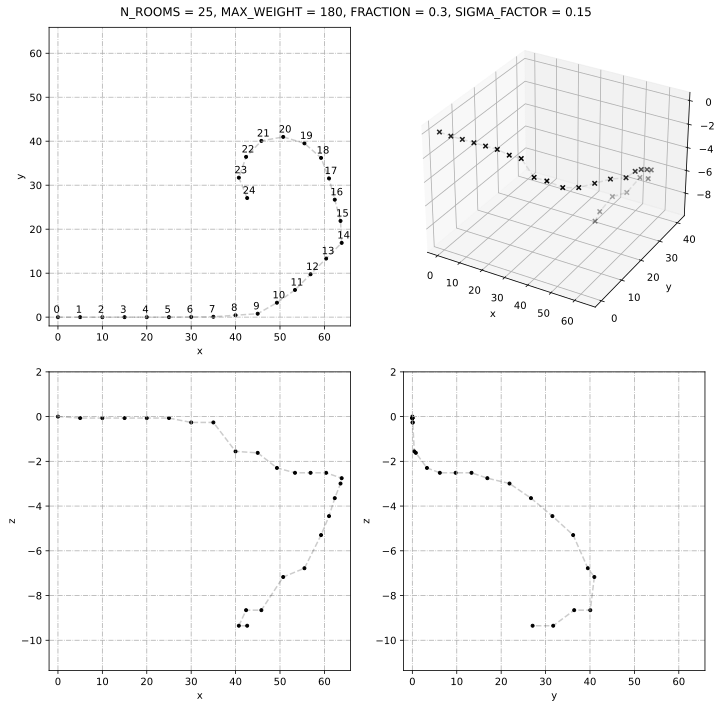

In [182]:
# @title Prototype
a = RoomPool(20)
a.populate()
mappa = Map(a)

# print(len(a.bins))
# for b in a.bins:
#     print(b)
#     for r in b.content:
#         print(r)
#     print()

# print(a.get_fullness())

instance_id: 0, id: 297, lr: 0, ud: 3.0, up: [], down: ['473, 1'], left: [], right: [], pos: [0, 0, 0], rotation: 0, base_weight: 6.0

instance_id: 1, id: 473, lr: 2.0, ud: 0, up: ['297, 0'], down: ['440, 2'], left: [], right: [], pos: [5.0, 0.0, -0.2616797812147192], rotation: 2.0, base_weight: 2.0

instance_id: 2, id: 440, lr: 18.0, ud: 4.25, up: ['473, 1'], down: ['473, 3'], left: [], right: [], pos: [9.996954135095478, 0.17449748351250485, -0.2616797812147192], rotation: 20.0, base_weight: 26.5

instance_id: 3, id: 473, lr: 2.0, ud: 0, up: ['440, 2'], down: ['490, 4'], left: [], right: [], pos: [14.695417239025021, 1.8845982001408483, -0.6322222321917154], rotation: 22.0, base_weight: 2.0

instance_id: 4, id: 490, lr: 22.5, ud: 0, up: ['473, 3'], down: ['81, 5'], left: [], right: [], pos: [19.331336511858957, 3.757631167220408, -0.6322222321917154], rotation: 44.5, base_weight: 22.5

instance_id: 5, id: 81, lr: 0, ud: 12.75, up: ['490, 4'], down: ['298, 6'], left: [], right: [], po